In [ ]:
%mkdir data
%mkdir data/chinese-mnist/

In [ ]:
for set_ in 'train','test','val':
    os.mkdir('data/chinese-mnist/'+set_)
    for i in range(1,16):
        os.mkdir('data/chinese-mnist/'+set_+'/'+str(i))

In [ ]:
%ls data/chinese-mnist/**

data/chinese-mnist/test:
1/  10/  11/  12/  13/  14/  15/  2/  3/  4/  5/  6/  7/  8/  9/

data/chinese-mnist/train:
1/  10/  11/  12/  13/  14/  15/  2/  3/  4/  5/  6/  7/  8/  9/

data/chinese-mnist/val:
1/  10/  11/  12/  13/  14/  15/  2/  3/  4/  5/  6/  7/  8/  9/


In [ ]:
df = pd.read_csv('/kaggle/input/chinese-mnist/chinese_mnist.csv')
length = df.shape[0]
perm =  np.random.permutation(length)
df_dict = {'test': perm[0:int(length*0.3)]}
df_dict['val'] = perm[int(length*0.3):int(length*0.4)]
df_dict['train'] = perm[int(length*0.4):]
for set_,perm_ in df_dict.items():
    df.iloc[perm_,:].apply(lambda x: 
                           copyfile('/kaggle/input/chinese-mnist/data/data/input_{0}_{1}_{2}.jpg'.format(
                                         x['suite_id'],
                                         x['sample_id'],
                                         x['code']),
                                     'data/chinese-mnist/{0}/{1}/input_{2}_{3}.jpg'.format(
                                         set_,
                                         x['code'],
                                         x['suite_id'],
                                         x['sample_id']
                                         )),axis=1)

In [ ]:
!find data/chinese-mnist/*/*/*.jpg | cut -d/ -f3-4 | sort | uniq -c

    328 test/1
    296 test/10
    255 test/11
    298 test/12
    304 test/13
    286 test/14
    312 test/15
    284 test/2
    343 test/3
    281 test/4
    307 test/5
    297 test/6
    330 test/7
    289 test/8
    290 test/9
    577 train/1
    634 train/10
    639 train/11
    600 train/12
    596 train/13
    615 train/14
    583 train/15
    608 train/2
    575 train/3
    617 train/4
    589 train/5
    606 train/6
    553 train/7
    602 train/8
    606 train/9
     95 val/1
     70 val/10
    106 val/11
    102 val/12
    100 val/13
     99 val/14
    105 val/15
    108 val/2
     82 val/3
    102 val/4
    104 val/5
     97 val/6
    117 val/7
    109 val/8
    104 val/9


(64, 64)


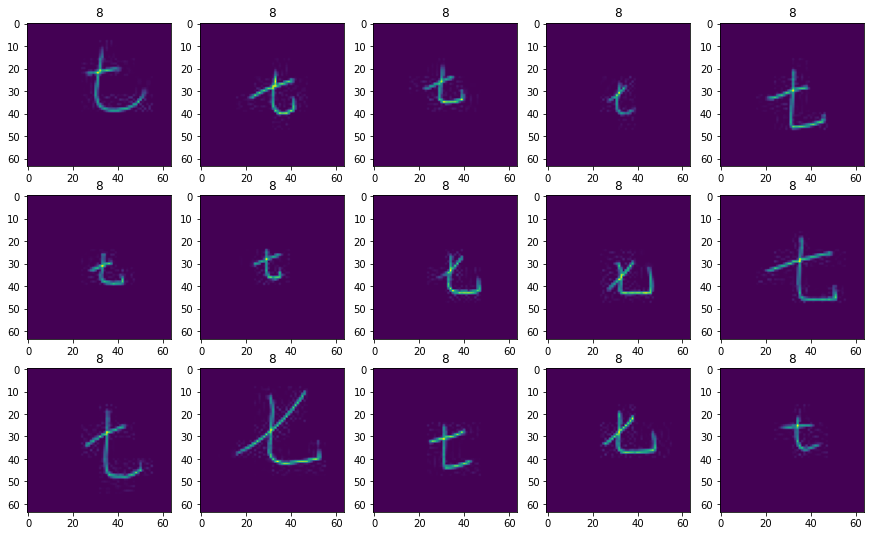

In [ ]:
files = glob('data/chinese-mnist/train/*/*jpg')
#@title sample images from the data set
fig, axes = plt.subplots(3,5, figsize=(15,9))
for i,ax in enumerate(axes.flat):
    x = plt.imread(files[i])
    y = files[i].split('/')[-2]
    ax.imshow(x.astype('uint8'))
    ax.set_title(y)
print(x.shape)

In [ ]:
data_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ColorJitter(55,55),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_ds = datasets.ImageFolder(root='data/chinese-mnist/train/',
                                           transform=data_transform)
training_generator = torch.utils.data.DataLoader(train_ds,
                                             batch_size=128, shuffle=True)

test_ds = datasets.ImageFolder(root='data/chinese-mnist/test/',
                                           transform=data_transform)
testing_generator = torch.utils.data.DataLoader(test_ds,
                                             batch_size=128, shuffle=True)

val_ds = datasets.ImageFolder(root='data/chinese-mnist/val/',
                                           transform=data_transform)
validation_generator = torch.utils.data.DataLoader(val_ds,
                                             batch_size=128, shuffle=True)

In [ ]:
#@title Manual Data Injection
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)
        x = F.relu(self.fc2(x))
        x = nn.Dropout(p=0.2)(x)        
        x = F.softmax(self.fc3(x),dim=1)
        return x

In [ ]:
optimizers = {'SGD':lambda x:optim.SGD(x.parameters(), lr=0.5, momentum=.5),
              'Adam':lambda x:optim.Adadelta(x.parameters(),lr=0.5),
              'RMSprop':lambda x:optim.RMSprop(x.parameters()),
              'Adadelta':lambda x:optim.Adadelta(x.parameters(),lr=0.5)}

loss_function = nn.CrossEntropyLoss()

In [ ]:
max_epochs = 100
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
mdl_pool = {}
for name,functional in optimizers.items():
    cnn = CNN()
    optimizer = functional(cnn)
    cnn.to(device)
    train_epoch_loss = [] 
    train_epoch_acc = [] 
    val_epoch_loss = []
    val_epoch_acc = [] 
    for epoch in range(max_epochs):
        cnn.train()
        running_loss = []
        running_acc = []
        for local_batch, local_labels in training_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(local_batch)
            loss = loss_function(outputs, local_labels)
            loss.backward()
            optimizer.step()
            running_loss += [loss.item()]
            _, predicted = torch.max(outputs, 1)
            running_acc += [(predicted == local_labels).sum().item()/training_generator.batch_size]
        train_epoch_loss += [np.mean(running_loss)]
        train_epoch_acc += [np.mean(running_acc)]
        
        cnn.eval()
        running_loss = []
        running_acc = []
        with torch.no_grad():
            for local_batch, local_labels in validation_generator:
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                outputs = cnn(local_batch)
                loss = loss_function(outputs, local_labels)
                running_loss += [loss.item()]
                _, predicted = torch.max(outputs, 1)
                running_acc += [(predicted == local_labels).sum().item()/validation_generator.batch_size]

        val_epoch_loss += [np.mean(running_loss)]
        val_epoch_acc += [np.mean(running_acc)]
        print('[{:d}] loss: {:7.5f} - acc: {:%} - val loss: {:7.5f} - val acc: {:%}'.format(epoch + 1,
                                                                                            train_epoch_loss[-1],
                                                                                            train_epoch_acc[-1],
                                                                                            val_epoch_loss[-1],
                                                                                            val_epoch_acc[-1]))
    mdl_pool[name]={}
    mdl_pool[name]['loss'] = train_epoch_loss
    mdl_pool[name]['acc'] = train_epoch_acc
    mdl_pool[name]['val_loss'] = val_epoch_loss
    mdl_pool[name]['val_acc'] = val_epoch_acc

cuda:0
[1] loss: 2.70801 - acc: 6.415053% - val loss: 2.70800 - val acc: 6.770833%
[2] loss: 2.70779 - acc: 6.767165% - val loss: 2.70779 - val acc: 6.380208%
[3] loss: 2.70642 - acc: 8.472711% - val loss: 2.70314 - val acc: 8.463542%
[4] loss: 2.67173 - acc: 13.237236% - val loss: 2.63288 - val acc: 15.885417%
[5] loss: 2.62664 - acc: 17.407570% - val loss: 2.59504 - val acc: 20.898438%
[6] loss: 2.58457 - acc: 22.337148% - val loss: 2.55085 - val acc: 25.455729%
[7] loss: 2.51699 - acc: 29.104313% - val loss: 2.54858 - val acc: 24.609375%
[8] loss: 2.49073 - acc: 31.679137% - val loss: 2.43930 - val acc: 36.328125%
[9] loss: 2.47384 - acc: 33.549736% - val loss: 2.46873 - val acc: 33.854167%
[10] loss: 2.43270 - acc: 37.819102% - val loss: 2.46776 - val acc: 34.049479%
[11] loss: 2.48609 - acc: 32.229313% - val loss: 2.56110 - val acc: 24.934896%
[12] loss: 2.50194 - acc: 31.095951% - val loss: 2.54729 - val acc: 26.236979%
[13] loss: 2.57503 - acc: 23.987676% - val loss: 2.74908 - v

[8] loss: 2.61647 - acc: 18.860035% - val loss: 2.60664 - val acc: 18.815104%
[9] loss: 2.59111 - acc: 21.225792% - val loss: 2.60445 - val acc: 19.596354%
[10] loss: 2.57500 - acc: 23.030370% - val loss: 2.55274 - val acc: 25.130208%
[11] loss: 2.54625 - acc: 26.364437% - val loss: 2.56444 - val acc: 23.763021%
[12] loss: 2.51850 - acc: 29.335387% - val loss: 2.50624 - val acc: 29.817708%
[13] loss: 2.49584 - acc: 31.371039% - val loss: 2.48310 - val acc: 32.812500%
[14] loss: 2.47046 - acc: 34.165933% - val loss: 2.46305 - val acc: 34.309896%
[15] loss: 2.43374 - acc: 38.105194% - val loss: 2.43804 - val acc: 37.109375%
[16] loss: 2.39419 - acc: 42.000440% - val loss: 2.40257 - val acc: 40.885417%
[17] loss: 2.37632 - acc: 43.816021% - val loss: 2.38834 - val acc: 41.406250%
[18] loss: 2.34689 - acc: 46.720951% - val loss: 2.33810 - val acc: 46.679688%
[19] loss: 2.31567 - acc: 49.900968% - val loss: 2.28204 - val acc: 52.408854%
[20] loss: 2.28635 - acc: 52.662852% - val loss: 2.330

[13] loss: 2.74623 - acc: 6.954225% - val loss: 2.77068 - val acc: 4.557292%
[14] loss: 2.74577 - acc: 6.976232% - val loss: 2.76926 - val acc: 4.622396%
[15] loss: 2.74667 - acc: 6.910211% - val loss: 2.76810 - val acc: 4.687500%
[16] loss: 2.74637 - acc: 6.965229% - val loss: 2.76850 - val acc: 4.622396%
[17] loss: 2.74582 - acc: 7.020246% - val loss: 2.76940 - val acc: 4.557292%
[18] loss: 2.74535 - acc: 7.042254% - val loss: 2.77068 - val acc: 4.557292%
[19] loss: 2.74661 - acc: 6.965229% - val loss: 2.77042 - val acc: 4.557292%
[20] loss: 2.74579 - acc: 6.998239% - val loss: 2.77031 - val acc: 4.492188%
[21] loss: 2.74659 - acc: 6.943222% - val loss: 2.76991 - val acc: 4.557292%
[22] loss: 2.74529 - acc: 6.976232% - val loss: 2.77031 - val acc: 4.492188%
[23] loss: 2.74659 - acc: 6.943222% - val loss: 2.76966 - val acc: 4.557292%
[24] loss: 2.74542 - acc: 6.987236% - val loss: 2.76977 - val acc: 4.622396%
[25] loss: 2.74615 - acc: 6.987236% - val loss: 2.76977 - val acc: 4.622396%

[20] loss: 2.31760 - acc: 49.702905% - val loss: 2.37896 - val acc: 42.773438%
[21] loss: 2.30155 - acc: 51.408451% - val loss: 2.29290 - val acc: 51.236979%
[22] loss: 2.26776 - acc: 54.610475% - val loss: 2.30549 - val acc: 50.195312%
[23] loss: 2.24527 - acc: 56.844190% - val loss: 2.29179 - val acc: 50.911458%
[24] loss: 2.21352 - acc: 60.068222% - val loss: 2.24072 - val acc: 56.054688%
[25] loss: 2.20711 - acc: 60.640405% - val loss: 2.20616 - val acc: 59.960938%
[26] loss: 2.17425 - acc: 63.842430% - val loss: 2.22608 - val acc: 57.552083%
[27] loss: 2.16729 - acc: 64.480634% - val loss: 2.18492 - val acc: 61.783854%
[28] loss: 2.13841 - acc: 67.407570% - val loss: 2.11286 - val acc: 68.619792%
[29] loss: 2.11144 - acc: 70.246479% - val loss: 2.13146 - val acc: 67.122396%
[30] loss: 2.10235 - acc: 70.961708% - val loss: 2.06388 - val acc: 74.218750%
[31] loss: 2.07569 - acc: 73.657570% - val loss: 2.07891 - val acc: 72.070312%
[32] loss: 2.05459 - acc: 75.858275% - val loss: 2.3

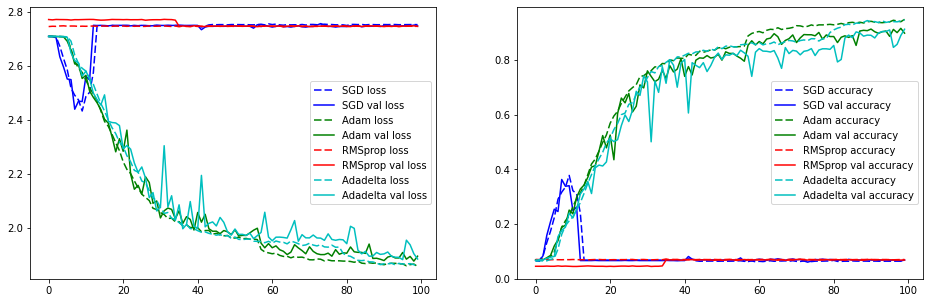

In [ ]:
#@title Plot Training History
plt.figure(figsize=(16,5))
c = ['b', 'g', 'r', 'c']
plt.subplot(121)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['loss'],linestyle=(0,(5,2)),color=c[i],label = name+' loss')
    plt.plot(item['val_loss'],color=c[i],label = name+' val loss')
plt.legend()

plt.subplot(122)
for i,(name,item) in enumerate(mdl_pool.items()):
    plt.plot(item['acc'],linestyle=(0,(5,2)),color=c[i],label = name +' accuracy')
    plt.plot(item['val_acc'],color=c[i],label = name+' val accuracy')
plt.legend()